# Introducción

Con el surgimiento de la pandemia del COVID-19, causado por el virus SARS-CoV-2, las redes sociales han sido el centro de intercambio de información para casi toda la población mundial, agregando el hecho que el confinamiento general promueve su uso por falta de contacto social físico. Pero de igual manera, la frecuente aparición de noticias falsas o fake news aumenta, creando pánico, desinformación, y duda en el público. Un ejemplo de red social muy famoso por su potencial de divulgación de fake news es Twitter, donde redes de usuarios comparten las ideas, posts, y enlaces que les parecen interesantes (o llamativos) mediante mensajes cortos llamados tweets.

Las redes sociales más usadas trabajan activamente para detectar y restringir la divulgación de fake news, pero aún no logran controlar este problema de una manera que se evite la desinformación masiva y constante que se vive durante esta cuarentena. Por esto surge la curiosidad de explorar el comportamiento, reacciones, y relaciones que suelen tener usuarios que interactúan con un tweet con información conspiratoria y falsa, específicamente relacionada a la pandemia. 

# Extracción de datos

Twitter provee un API de HTTP para la interacción con su plataforma, lo cual nos sirve para extraer la información que deseamos analizar. Desarrollé un script de Python `tweets_to_csv.py` que utiliza la librería Tweepy para manejar los pedidos a Twitter. Para esto, es necesario obtener credenciales para una aplicación de Twitter desde el portal de desarrollador de la plataforma. Este script hace una búsqueda exhaustiva de tweets basados en un string de búsqueda (utilizando sintaxis de búsqueda de Twitter) y guarda los tweets recuperados en archivos `.csv` bajo el directorio `/data`. Esta búsqueda se detiene cuando llega al límite de pedidos al API de Twitter, el cual es 450 pedidos cada 5 minutos aproximadamente. Cada pedido recupera hasta 100 tweets, y estos contienen información sobre sus reacciones, usuarios emisores, hashtags, URLs, geolocación, etc.

Para la colección total de datos, decidí enfocarme en 3 hashtags:
    * #covid19
    * #FilmYourHospital
    * #Plandemic
    
Escogí #covid19 por razones obvias, pero más que nada porque es uno de los hashtags más populares en este período de la historia humana. 

El segundo hashtag es muy interesante por dos razones; muchas personas lo utlizan a favor de teorías conspirativas y vídeos que promueven la idea de que los hospitales de las ciudades más afectadas del mundo (e.g.: NYC, USA) están visiblemente vacíos a pesar de la emergencia sanitaria, pero esto ha sido corroborado por el personal de dichos hospitales (Gruzd, Mai, s/f). Además, por el mismo hecho de que muchas personas promulgaban esta idea, Twitter hizo un *shadow ban* al hashtag #FilmYourHospital, lo cual significa que ese hashtag está bloqueado de las sugerencias de búsqueda en la aplicación para usuarios.

Así mismo, el tercer hashtag lo escogí por su popularidad y por su relación con teorías consppirativas. Sobre todo, este existe una mini película en línea llamada Plandemic que ha sido removida de YouTube y Facebook por su insistencia en que la emergencia sanitaria mundial es en realidad un plan de las élites mundiales (Herbert, 2020).

Con este criterio, se corrió el script múltiples veces durante varios días para armar recopilado local de información. Es importante mencionar que el API de Twitter devuelve solo los tweets más actuales, y la búsqueda de tweets de más de una semana atrás es una característica Premium del API, la cual no dispongo para este proyecto.

# Carga de datos

Una vez descargada la información a analizar, se carga al código a través de `pandas.DataFrame`. A continuación se definen las librerías a usar y las credenciales para la aplicación.

In [1]:
import twitter
import tweepy
import pandas as pd
import numpy as np
import networkx as nx
import descartes
import geopandas as gpd
import os
import re
import nltk
from nltk.corpus import stopwords
from datetime import datetime
from nltk.tokenize import word_tokenize
import datetime as dt
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download('punkt');
nltk.download('stopwords')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

app_key = ''
app_key_secret = ''
auth = tweepy.AppAuthHandler(app_key, app_key_secret)
api = tweepy.API(auth)

[nltk_data] Downloading package punkt to C:\Users\Juan
[nltk_data]     Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Juan
[nltk_data]     Javier\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Se leen los archivos.

In [2]:
df = pd.DataFrame()
path = 'data'
filenames = os.listdir('data')

print(f'Reading {len(filenames)} files ...')
for i, filename in enumerate(filenames):
    df = df.append(pd.read_csv(path+'/'+filename), ignore_index=True, sort=True)
    print('_', end='')
print('!')

Reading 843 files ...
___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________!


In [3]:
df = df.drop_duplicates('id').set_index('id', verify_integrity=True)
df['entities'] = df['entities'].apply(lambda e: eval(e))
df['user'] = df['user'].apply(lambda e: eval(e))
print(f'You have a total of {len(df)} unique tweets in this DataFrame.')

You have a total of 68122 unique tweets in this DataFrame.


Se separan los tweets según algunas características.

In [4]:
df.columns.to_list()
df_geo = df.dropna(subset=['coordinates'])
print(f'There are {len(df_geo)} tweets with coordinates data.')
df_covid19 = df[df['entities'].apply(lambda e: True if any([('covid19' == h['text'].lower()) for h in e['hashtags']]) else False)]
print(f'There are {len(df_covid19)} tweets with #covid19')
df_filmyourhospital = df[df['entities'].apply(lambda e: True if any([('filmyourhospital' in h['text'].lower()) for h in e['hashtags']]) else False)]
print(f'There are {len(df_filmyourhospital)} tweets with #filmyourhospital')
df_plandemic = df[df['entities'].apply(lambda e: True if any([('plandemic' == h['text'].lower()) for h in e['hashtags']]) else False)]
print(f'There are {len(df_plandemic)} tweets with #plandemic')

There are 49 tweets with coordinates data.
There are 31481 tweets with #covid19
There are 1244 tweets with #filmyourhospital
There are 7456 tweets with #plandemic


# Escoger un Tweet

Para la decisión de escoger un tweet para analizar existen muchas opciones. Para este caso hice una búsqueda de tweets que comparten links, pero que a su vez no pertenezcan a usuarios verificados. Además hice un filtrado de todos los tweets recuperados, y los ordené según las veces que hayan sido retweeteados.

## Tweets que divulgan URLs

In [5]:
_df_urls = df['entities'].apply(lambda e: e['urls'][0]['display_url'] if e['urls'] else np.nan).dropna()
_df_urls = _df_urls.apply(lambda e: e if 'twitter' not in e else np.nan).dropna()
_df_urls_bitly = _df_urls.apply(lambda e: e if '.ly/' in e else np.nan).dropna()
_df_urls_not_bitly = _df_urls.apply(lambda e: e if '.ly/' not in e else np.nan).dropna()

df_urls = df.loc[_df_urls.index]
df_urls['url'] = _df_urls
df_urls['verified'] = df_urls['user'].apply(lambda u: u['verified'])

df_urls_unverified = df_urls[df_urls['verified'] == False]

Se pueden encontrar tweets que promulgan fake news según los hashtags buscados. Agrego un último filtro para ver solo tweets que no sean retweets o quotes.

In [44]:
# Look for tweets that point to fake information
df_urls_unverified[df_urls['retweeted_status'].isna()].sort_values('retweet_count', ascending=False)[['text', 'user', 'favorite_count', 'retweet_count', 'retweeted_status', 'url']];

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Después de una búsqueda rápida, encontré tres tweets que compartían desinformación y que tenían un decente grado de interacción con usuarios. Anoté los IDs de cada uno en una lista:

In [7]:
fake_tweets = [
    1257452897731739650,    # "Nurse says they are killing patients"
    1258114910770262016,    # Plandemic movie promotion
    1257860570222432256     # Plandemic movie promotion
]

# Reacciones

Se desea ver el nivel de interacción que tienen estos tweets con usuarios, y la frecuencia de interacción de usuarios con el originador de cada tweet. Para esto se pueden ver los Favs y Retweets que tienen los tweets.

## Favs

Un Fav es una forma de darle *Like* a un tweet.

In [8]:
tweet1 = api.get_status(fake_tweets[0])
favs = int(tweet1.favorite_count)
print(f'Tweet #1 has been favorited {favs} times.')


tweet2 = api.get_status(fake_tweets[1])
favs = int(tweet2.favorite_count)
print(f'Tweet #2 has been favorited {favs} times.')


tweet3 = api.get_status(fake_tweets[2])
favs = int(tweet3.favorite_count)
print(f'Tweet #3 has been favorited {favs} times.')


Tweet #1 has been favorited 19 times.
Tweet #2 has been favorited 3 times.
Tweet #3 has been favorited 22 times.


Sin embargo, la información del número de favs no nos sirve de mucho y el API de Twitter no provee información sobre los usuarios que dan *Fav* a un tweet, pero sí da un listado de usuarios que le hacen retweet.

## Retweets

Un retweet es un tweet que referencia a otro tweet para divulgarlo.

### Tweet 1

In [9]:
print("User:")
print(tweet1.user.screen_name)
print("\nText:\n_______________________________________________________________")
print(tweet1.text)
rets = int(tweet1.retweet_count)
print(f'_______________________________________________________________\n\nThis tweet has been retweeted {rets} times.')

User:
HealthyNews2day

Text:
_______________________________________________________________
Nevada Nurse in NYC: COVID is NOT Killing People – They’re Being Murdered

Read more&gt;&gt; https://t.co/JGmaLpjpyx… https://t.co/cyG3IJ25d6
_______________________________________________________________

This tweet has been retweeted 11 times.


In [10]:
retweets = tweet1.retweets()
users = []
for retweet in retweets:
    _user = retweet.user
    users.append(_user)
    
print(f'{len(users)} retweeting users retrieved from tweet.')

9 retweeting users retrieved from tweet.


La diferencia del número de veces que el tweet ha sido retweeteado con el número de retweets que el API nos devuelve puede ser porque una porción de los retweets pertenecen a cuentas privadas. A continuación se muestra un simple grafo sobre las conexiones del tweet con los usuarios que le hicieron retweet. La librería usada para el grafo es NetworkX, y la dirección de los edges indica quién hizo retweet a quién (los nombres mostrados en los nodos son los usuarios). 

Nodes of graph: 
10
Edges of graph: 
9


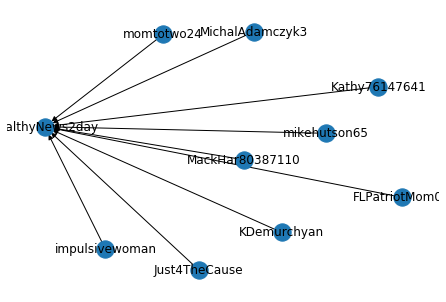

In [11]:
tweet_username = tweet1.user.screen_name
edge_dict = {}

for u in users:
    rt_username = u.screen_name
    edge = (rt_username, tweet_username)
    
    if edge in edge_dict:
        edge_dict[edge] = edge_dict[edge] + 1
    else:
        edge_dict[edge] = 1

G_retweets = nx.DiGraph()

for key, value in edge_dict.items():
    G_retweets.add_edge(key[0], key[1], weight=1/value)

print("Nodes of graph: ")
print(len(G_retweets.nodes()))

print("Edges of graph: ")
print(len(G_retweets.edges()))


#se dibuja el grafo.
nx.draw(G_retweets, with_labels=True)
#nx.draw_circular(G_retweets, with_labels=True)
plt.show()

In [12]:
# Función para armar un diccionario de edges que dirigen una lista de usuarios a un usuario originador
def add_edges(edge_dict, tweet_username, users):
    for u in users:
        rt_username = u.screen_name
        edge = (rt_username, tweet_username)

        if edge in edge_dict:
            edge_dict[edge] = edge_dict[edge] + 1
        else:
            edge_dict[edge] = 1
    
    return edge_dict

Ahora deberíamos ver el nivel de interacción que tienen los últimos tweets del usuario que produjo este tweet. Para eso busco los tweets en la lista de sus últimos tweets, o timeline. El API solo nos permite obtener una cantidad limitada de tweets del timeline a la vez. Identifico los usuarios que han hecho retweet a cada tweet del timeline, y los agrego a un grafo. Los pesos y direcciones de los edges corresponden a la cantidad de veces que un usuario le hizo retweet al usuario analizado.

In [13]:
timeline = api.user_timeline(tweet1.user.id)

for t in timeline:
    users = [rt.user for rt in t.retweets()]
    edge_dict = add_edges(edge_dict, tweet_username, users)

Nodes of graph: 
63
Edges of graph: 
62
Highest weight:
MackHar80387110 8


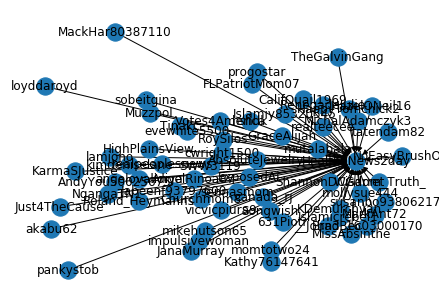

In [14]:
G_retweets = nx.DiGraph()

for key, value in edge_dict.items():
    G_retweets.add_edge(key[0], key[1], weight=1/value)

print("Nodes of graph: ")
print(len(G_retweets.nodes()))

print("Edges of graph: ")
print(len(G_retweets.edges()))

print("Highest weight:")
print(max(edge_dict, key=edge_dict.get)[0], edge_dict[max(edge_dict, key=edge_dict.get)])

#se dibuja el grafo.
nx.draw(G_retweets, with_labels=True)
#nx.draw_circular(G_retweets, with_labels=True)
plt.show()

En este grafo existe un nodo central, que corresponde al usuario de este tweet. El grafo se construyó de tal forma que mientras más lejos se encuentra un nodo, ese usuario ha hecho más retweets al usuario central.

### Tweet 2

De igual forma se realiza el mismo análisis para los otros dos tweets.

In [15]:
print("User:")
print(tweet2.user.screen_name)
print("\nText:\n_______________________________________________________________")
print(tweet2.text)
rets = int(tweet2.retweet_count)
print(f'_______________________________________________________________\n\nThis tweet has been retweeted {rets} times.')

User:
unrealpost

Text:
_______________________________________________________________
#Plandemic the movie. Only 26 minutes. 
Wake up sheep!

https://t.co/k2LnoPInfJ

#COVIDgod
#thebeastsystem https://t.co/vibsNP869u
_______________________________________________________________

This tweet has been retweeted 4 times.


In [16]:
retweets = tweet2.retweets()
users = []
for retweet in retweets:
    _user = retweet.user
    users.append(_user)
    
print(f'{len(users)} retweeting users retrieved from tweet.')

4 retweeting users retrieved from tweet.


In [17]:
tweet_username = tweet2.user.screen_name
edge_dict = {}

for u in users:
    rt_username = u.screen_name
    edge = (rt_username, tweet_username)
    
    if edge in edge_dict:
        edge_dict[edge] = edge_dict[edge] + 1
    else:
        edge_dict[edge] = 1

G_retweets = nx.DiGraph()

for key, value in edge_dict.items():
    G_retweets.add_edge(key[0], key[1], weight=1/value)

In [18]:
timeline = api.user_timeline(tweet2.user.id)

for t in timeline:
    users = [rt.user for rt in t.retweets()]
    edge_dict = add_edges(edge_dict, tweet_username, users)

Nodes of graph: 
12
Edges of graph: 
11
Highest weight:
jamiepantastico 8


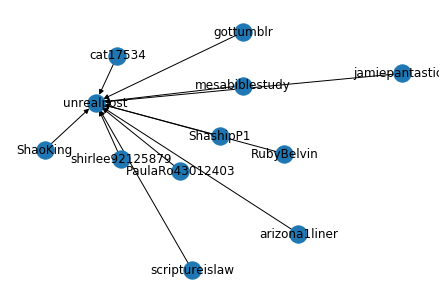

In [19]:
G_retweets = nx.DiGraph()

for key, value in edge_dict.items():
    G_retweets.add_edge(key[0], key[1], weight=1/value)

print("Nodes of graph: ")
print(len(G_retweets.nodes()))

print("Edges of graph: ")
print(len(G_retweets.edges()))

print("Highest weight:")
print(max(edge_dict, key=edge_dict.get)[0], edge_dict[max(edge_dict, key=edge_dict.get)])



#se dibuja el grafo.
nx.draw(G_retweets, with_labels=True)
#nx.draw_circular(G_retweets, with_labels=True)
plt.show()

### Tweet 3

In [20]:
print("User:")
print(tweet3.user.screen_name)
print("\nText:\n_______________________________________________________________")
print(tweet3.text)
rets = int(tweet3.retweet_count)
print(f'_______________________________________________________________\n\nThis tweet has been retweeted {rets} times.')

User:
RobynAnne

Text:
_______________________________________________________________
Plandemic Documentary: The Hidden Agenda Behind Covid-19 https://t.co/QCPuguejUk via @YouTube #AbuseOfPower… https://t.co/BZQ2PIKpXB
_______________________________________________________________

This tweet has been retweeted 27 times.


In [21]:
retweets = tweet3.retweets()
users = []
for retweet in retweets:
    _user = retweet.user
    users.append(_user)
    
print(f'{len(users)} retweeting users retrieved from tweet.')

20 retweeting users retrieved from tweet.


In [22]:
tweet_username = tweet3.user.screen_name
edge_dict = {}

for u in users:
    rt_username = u.screen_name
    edge = (rt_username, tweet_username)
    
    if edge in edge_dict:
        edge_dict[edge] = edge_dict[edge] + 1
    else:
        edge_dict[edge] = 1

G_retweets = nx.DiGraph()

for key, value in edge_dict.items():
    G_retweets.add_edge(key[0], key[1], weight=1/value)

In [23]:
timeline = api.user_timeline(tweet3.user.id)

for t in timeline:
    users = [rt.user for rt in t.retweets()]
    edge_dict = add_edges(edge_dict, tweet_username, users)

Nodes of graph: 
40
Edges of graph: 
40
Highest weight:
HorseShort 2


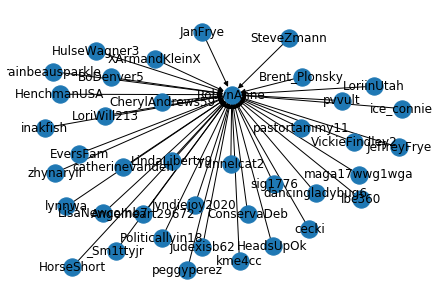

In [24]:
G_retweets = nx.DiGraph()

for key, value in edge_dict.items():
    G_retweets.add_edge(key[0], key[1], weight=1/value)

print("Nodes of graph: ")
print(len(G_retweets.nodes()))

print("Edges of graph: ")
print(len(G_retweets.edges()))

print("Highest weight:")
print(max(edge_dict, key=edge_dict.get)[0], edge_dict[max(edge_dict, key=edge_dict.get)])


#se dibuja el grafo.
nx.draw(G_retweets, with_labels=True)
#nx.draw_circular(G_retweets, with_labels=True)
plt.show()

# Traceback de un Tweet

El API de Twitter provee información muy variada con cada llamada, incluyendo el tweet original cuando se trada de un retweet. Con esto se hace trivial la búsqueda en cadena hasta llegar a un tweet que no sea retweet. Los tweets que estamos analizando no correponden a un retweet o un quote como tal, así que no tenemos una forma directa de enlazar y encontrar el primer tweet que hizo mención a su contenido. Sin embargo, podemos buscar tweets que tengan textos similares y filtrarlos por fecha de creación. Vamos a realizar esta búsqueda con el contenido del Tweet 1.

Para esto utilicé una librería para tokenizar el texto del tweet, `nltk`. Puedo procesar el texto para remover links, puntuaciones, remover palabras irrelevantes, y reducirlo a su forma semántica más simple. Con esto puedo buscar tweets que tengan relación a esta información.

In [25]:
text = tweet1.text
text = re.sub(r'http\S+', '', text)
text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
words = word_tokenize(text)
words = [w for w in words if w not in stopwords.words()]
words = [w for w in words if w != "gt" and w !='read']

text = ''
for w in words:
    text = text + w + ' '
print("Tokenized tweet:\n\t"+text)

Tokenized tweet:
	nevada nurse nyc covid killing people murdered 


In [26]:
_tweets = []
for tweet in tweepy.Cursor(api.search, q=text).items(100):
    _tweets.append(tweet._json)
df_tweets = pd.DataFrame.from_dict(_tweets)
df_tweets = df_tweets.dropna(subset=['retweeted_status'])
df_tweets['this_tweet_user'] = df_tweets['user'].apply(lambda u: u['screen_name'])
df_tweets['this_tweet_user_create_year'] = df_tweets['user'].apply(lambda u: int(u['created_at'].split()[-1]))
df_tweets['retweeted_user'] = df_tweets['retweeted_status'].apply(lambda r: r['user']['screen_name'])
df_tweets['retweeted_user_create_year'] = df_tweets['retweeted_status'].apply(lambda r: int(r['user']['created_at'].split()[-1]))

df_recent_users = df_tweets[['text', 'this_tweet_user', 'this_tweet_user_create_year', 'retweeted_user', 'retweeted_user_create_year']].sort_values('this_tweet_user_create_year', ascending=False)

Lamentablemente, con los accesos de API que tengo no puedo obtener tweets filtrados por el tiempo; siempre obtengo los más recientes y nunca puedo saber el primer tweet que compartió esta información. Aparte, solo puedo obtener máximo 100 en una llamada.

Por otro lado, sí puedo obtener la información de los usuarios que comparten tweets sobre la misma historia y analizarlos en base a una muestra. Filtré los tweets para tener solo retweets de esta información, y analicé la fecha de creación de los usuarios que hicieron los retweets, y los usuarios a los quev hicieron retweet.

The most common create date for users retweeting are
	* 2009: 16.67%
	* 2020: 15.0%
	* 2014: 11.67%


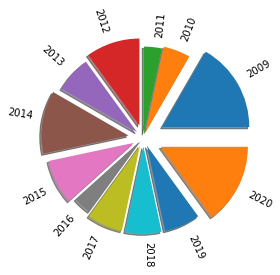

In [27]:
_averages = df_recent_users.drop_duplicates('this_tweet_user')[['this_tweet_user_create_year', 'this_tweet_user']].groupby('this_tweet_user_create_year')
proportions = _averages.count().apply(lambda x: x/x.sum()).values.tolist()
proportions = [p[0] for p in proportions]
years = _averages.count().apply(lambda x: x/x.sum()).index.tolist()
_averages = pd.DataFrame([years,proportions]).transpose().rename(columns={0:'years', 1:'proportions'}).set_index('years')
plt.pie(proportions, labels=years, explode=[p*1.5 for p in proportions], rotatelabels=True, shadow=True);

_averages = _averages.sort_values('proportions', ascending=False)
print(f"The most common create date for users retweeting are\n\t* {int(_averages.iloc[0].name)}: {round(_averages.iloc[0].item()*100,2)}%\n\t* {int(_averages.iloc[1].name)}: {round(_averages.iloc[1].item()*100,2)}%\n\t* {int(_averages.iloc[2].name)}: {round(_averages.iloc[2].item()*100,2)}%")

En el caso de los usuarios que hicieron retweet, se puede notar una grande proporción de usuarios creados recientemente, pero no también se ven bastantes usuarios creados en el 2009.

The most common create date for the retweeted users are:
	* 2018: 38.46%
	* 2009: 15.38%
	* 2016: 15.38%


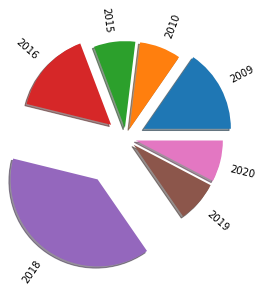

In [28]:
_averages = df_recent_users.drop_duplicates('retweeted_user')[['retweeted_user_create_year', 'retweeted_user']].groupby('retweeted_user_create_year')
proportions = _averages.count().apply(lambda x: x/x.sum()).values.tolist()
proportions = [p[0] for p in proportions]
years = _averages.count().apply(lambda x: x/x.sum()).index.tolist()
_averages = pd.DataFrame([years,proportions]).transpose().rename(columns={0:'years', 1:'proportions'}).set_index('years')
plt.pie(proportions, labels=years, explode=[p*1.5 for p in proportions], rotatelabels=True, shadow=True);

_averages = _averages.sort_values('proportions', ascending=False)
print(f"The most common create date for the retweeted users are:\n\t* {int(_averages.iloc[0].name)}: {round(_averages.iloc[0].item()*100,2)}%\n\t* {int(_averages.iloc[1].name)}: {round(_averages.iloc[1].item()*100,2)}%\n\t* {int(_averages.iloc[2].name)}: {round(_averages.iloc[2].item()*100,2)}%")

Curiosamente, una gran proporción de los usuarios que generaron el contenido inicial fueron creados solo en el 2018.

# User de un Tweet

Para el mismo usuario del tweet analizado deseamos visualizar su red de seguidos (followings) y seguidores (followers). A continuación se muestra información general sobre el usuario.

In [29]:
user = tweet1.user._json
print("ID:\n\t"+str(user['id']))
print("Name:\n\t"+user['name'])
print("Username:\n\t"+user['screen_name'])
print("Description:\n\t"+user['description'])
print("Follows:\n\t"+str(user['friends_count']))
print("Followed by:\n\t"+str(user['followers_count']))
print("Tweets:\n\t"+str(user['statuses_count']))
print("Create date:\n\t"+user['created_at'])
print("URL:\n\t"+user['entities']['url']['urls'][0]['expanded_url'])

user = api.get_user(user['id'])
followings = user.friends(count=20)
followers = user.followers(count=20)

ID:
	236696328
Name:
	Health Impact News
Username:
	HealthyNews2day
Description:
	Twitter feed for Health Impact News. News that impacts your health that you may not find from other media sources. Editor Brian Shilhavy.
Follows:
	25197
Followed by:
	58830
Tweets:
	7947
Create date:
	Tue Jan 11 04:53:49 +0000 2011
URL:
	http://HealthImpactNews.com


## Followings

Primero grafico un grafo de dos niveles de profundidad de los usuarios a los que el usuario central sigue. Son dos niveles porque muestro los usuarios que sigue el usuario, y también los usuarios de esos usuarios. Debido a los límites del API, solo puedo obetener una muestra de 20 usuarios por búsqueda.

In [30]:
# Función para agregar edges a un dict. Añade un peso a cada nodo según hace cuántos años fue creado el usuario.
def add_edges_followings(edge_dict, tweet_user, users):
    tweet_username = tweet_user.screen_name
    for u in users:
        rt_username = u.screen_name
        edge = (tweet_username, rt_username)

        value2 = round(datetime.now().year - u.created_at.year)
        value1 = round(datetime.now().year - tweet_user.created_at.year)
        
        edge_dict[edge] = (value1, value2)
    
    return edge_dict

In [31]:
# Se construye el diccionario de edges para el grafo
edge_dict = {}
edge_dict = add_edges_followings(edge_dict, user, followings)

for u in followings:
    u_name = u.screen_name
    
    try:
        _followings = u.friends()
        add_edges_followings(edge_dict, u, _followings)
            
        for _u in _followings:
            _u_name = _.screen_name
            
            try:
                __followings = _u.friends()
                add_edges_followings(edge_dict, _u, __followings)

            except:
                pass
    except:
        pass

Nodes of graph: 
181
Edges of graph: 
180


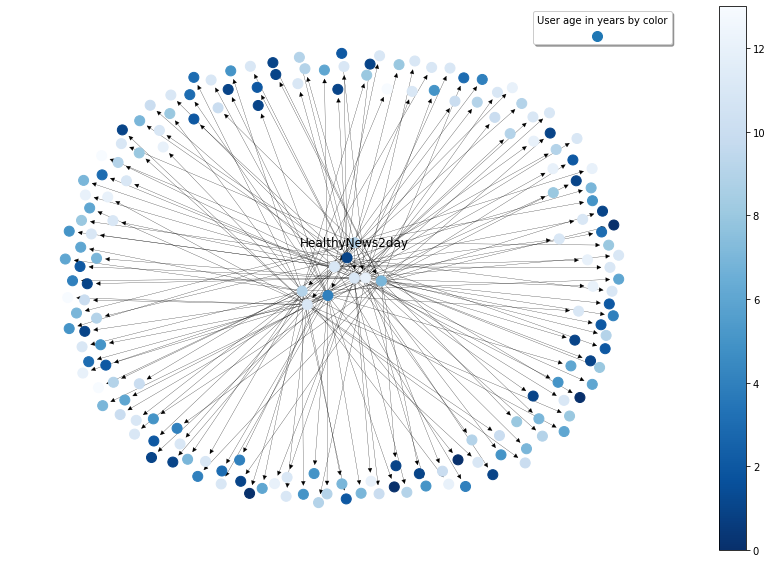

In [32]:
# Se construye el grafo
G = nx.DiGraph()
for key, value in edge_dict.items():
    G.add_node(key[0], weight=value[0])
    G.add_node(key[1], weight=value[1])
    G.add_edge(key[0], key[1])

print("Nodes of graph: ")
print(len(G.nodes()))

print("Edges of graph: ")
print(len(G.edges()))


labels = {
    n: (n
        if n==user.screen_name
        else '')
    for n in G.nodes
}
colors = [n[1]['weight'] for n in G.nodes().data()]
pos = nx.spring_layout(G)
plt.figure(figsize=(15,10))
ec = nx.draw_networkx_edges(G, pos, width=0.25)
nc = nx.draw_networkx_nodes(G, pos, label=" ", cmap=plt.cm.Blues_r, node_size=100, width=0.25, node_color=colors)
l = nx.draw_networkx_labels(G, pos, labels=labels)

plt.colorbar(nc)
plt.axis('off')
plt.legend(shadow=True, title='User age in years by color')
plt
plt.show()

En este grafo las direcciones de los enlaces indica un usuario que sigue a otro usuario. El color de cada nodo indica la antiguedad en años de esa cuenta, siendo las cuentas más jóvenes de color más oscuro.

De igual forma, se analiza la proporción de fecha de creación de los usuarios en este grafo.

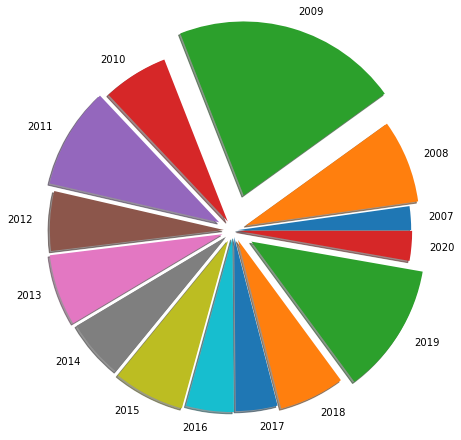

In [33]:
_data = pd.DataFrame([datetime.now().year-val for val in colors])
_data['pct'] = 0
_data = _data.groupby(0)
proportions = _data.count().apply(lambda x: x/x.sum()).values.tolist()
proportions = [p[0] for p in proportions]
years = _data.count().apply(lambda x: x/x.sum()).index.tolist()
plt.pie(proportions, labels=years, explode=[p*2.0 for p in proportions], shadow=True, radius=2);

Existe una mayor proporción de usuarios creados en los priimeros años de Twitter, pero es comparable con usuarios más recientes.

## Followers

De igual forma que se hizo con la red de seguidos por el usuario analizado, vamos a ver una red de usuarios que siguen a este usuario, y los usuarios que siguen a esos usuarios.

In [34]:
# Función para agregar edges a un dict. Añade un peso a cada nodo según hace cuántos años fue creado el usuario.
def add_edges_followers(edge_dict, tweet_user, users):
    tweet_username = tweet_user.screen_name
    for u in users:
        rt_username = u.screen_name
        edge = (rt_username, tweet_username)

        value1 = round(datetime.now().year - u.created_at.year)
        value2 = round(datetime.now().year - tweet_user.created_at.year)
        
        edge_dict[edge] = (value1, value2)
    
    return edge_dict

In [35]:
# Se construye el diccionario de edges para el grafo 
edge_dict = {}
edge_dict = add_edges_followers(edge_dict, user, followers)

for u in followers:
    u_name = u.screen_name
    
    try:
        _followers = u.followers()
        add_edges_followers(edge_dict, u, _followers)
            
        for _u in _followers:
            _u_name = _.screen_name
            
            try:
                __followers = _u.followers()
                add_edges_followers(edge_dict, _u, __followers)

            except:
                pass
    except:
        pass

Nodes of graph: 
274
Edges of graph: 
274


No handles with labels found to put in legend.


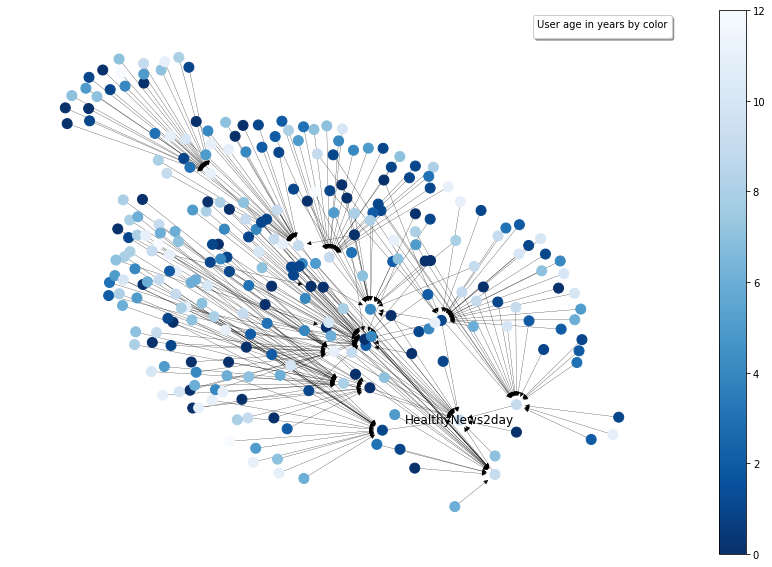

In [36]:
# Se construye el grafo
G = nx.DiGraph()
colors = []
for key, value in edge_dict.items():
    #colors.append(value)
    G.add_node(key[0], weight=value[0])
    G.add_node(key[1], weight=value[1])
    G.add_edge(key[0], key[1])

print("Nodes of graph: ")
print(len(G.nodes()))

print("Edges of graph: ")
print(len(G.edges()))


labels = {
    n: (n
        if n==user.screen_name
        else '')
    for n in G.nodes
}
colors = [n[1]['weight'] for n in G.nodes().data()]

pos = nx.spring_layout(G)
plt.figure(figsize=(15,10))
ec = nx.draw_networkx_edges(G, pos, width=0.25)
nc = nx.draw_networkx_nodes(G, pos, label="", cmap=plt.cm.Blues_r, node_size=100, width=0.25, node_color=colors)
l = nx.draw_networkx_labels(G, pos, labels=labels)

plt.colorbar(nc)
plt.axis('off')
plt.legend(shadow=True, title='User age in years by color')
plt.show()


De igual manera, en este grafo las direcciones de los enlaces indica un usuario que sigue a otro usuario. El color de cada nodo indica la antiguedad en años de esa cuenta, siendo las cuentas más jóvenes de color más oscuro.

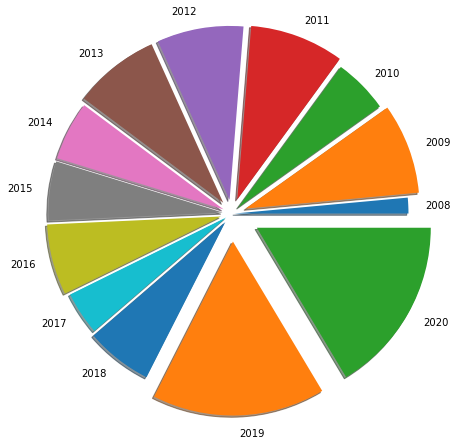

In [37]:
_data = pd.DataFrame([datetime.now().year-val for val in colors])
_data['pct'] = 0
_data = _data.groupby(0)
proportions = _data.count().apply(lambda x: x/x.sum()).values.tolist()
proportions = [p[0] for p in proportions]
years = _data.count().apply(lambda x: x/x.sum()).index.tolist()
plt.pie(proportions, labels=years, explode=[p*2.0 for p in proportions], shadow=True, radius=2);

Para el caso de los seguidores de esta cuenta, existe una notable mayoría de usuarios creados recientemente en este y el anterior año.

## Grafo completo de conexiones del User

Para hacer este ejercicio más interesante, vamos a unificar ambos grafos para ver una muestra de la red completa de usuarios que interactúan con este usuario central.

In [38]:
# Followings
edge_dict = {}
edge_dict = add_edges_followings(edge_dict, user, followings)

for u in followings:
    u_name = u.screen_name
    
    try:
        _followings = u.friends()
        add_edges_followings(edge_dict, u, _followings)
            
        for _u in _followings:
            _u_name = _.screen_name
            
            try:
                __followings = _u.friends()
                add_edges_followings(edge_dict, _u, __followings)

            except:
                pass
    except:
        pass

# Followers
edge_dict = add_edges_followers(edge_dict, user, followers)

for u in followers:
    u_name = u.screen_name
    
    try:
        _followers = u.followers()
        add_edges_followers(edge_dict, u, _followers)
            
        for _u in _followers:
            _u_name = _.screen_name
            
            try:
                __followers = _u.followers()
                add_edges_followers(edge_dict, _u, __followers)

            except:
                pass
    except:
        pass

Nodes of graph: 
253
Edges of graph: 
252


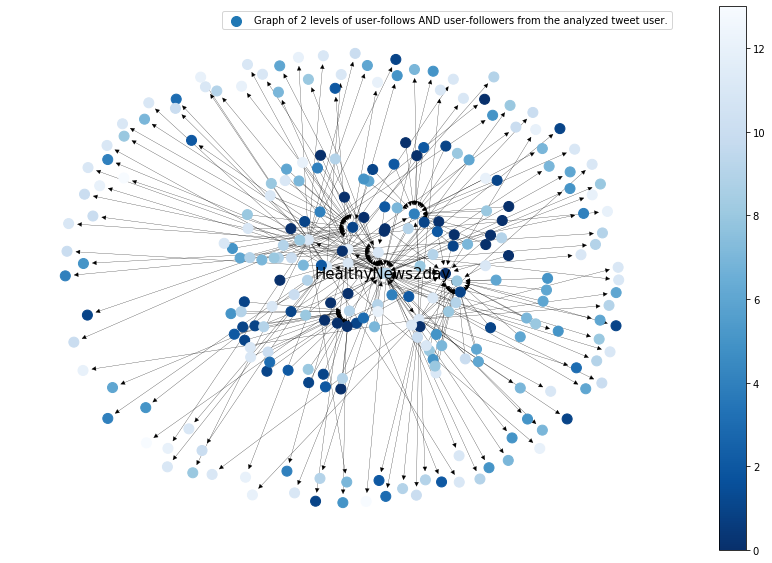

In [39]:
G = nx.DiGraph()
for key, value in edge_dict.items():
    G.add_node(key[0], weight=value[0])
    G.add_node(key[1], weight=value[1])
    G.add_edge(key[0], key[1])

print("Nodes of graph: ")
print(len(G.nodes()))

print("Edges of graph: ")
print(len(G.edges()))


labels = {
    n: (n
        if n==user.screen_name
        else '')
    for n in G.nodes
}
colors = [n[1]['weight'] for n in G.nodes().data()]

pos = nx.spring_layout(G, k=0.25)
plt.figure(figsize=(15,10))
ec = nx.draw_networkx_edges(G, pos, width=0.25)
nc = nx.draw_networkx_nodes(G, pos, label="Graph of 2 levels of user-follows AND user-followers from the analyzed tweet user.", cmap=plt.cm.Blues_r, node_size=100, width=0.25, node_color=colors)
l = nx.draw_networkx_labels(G, pos, labels=labels,  font_size=15)

plt.colorbar(nc)
plt.axis('off')
plt.legend()
plt.show()

En este grafo se puede notar el nodo central analizado, marcado por su nombre de usuario en el centro del grafo.

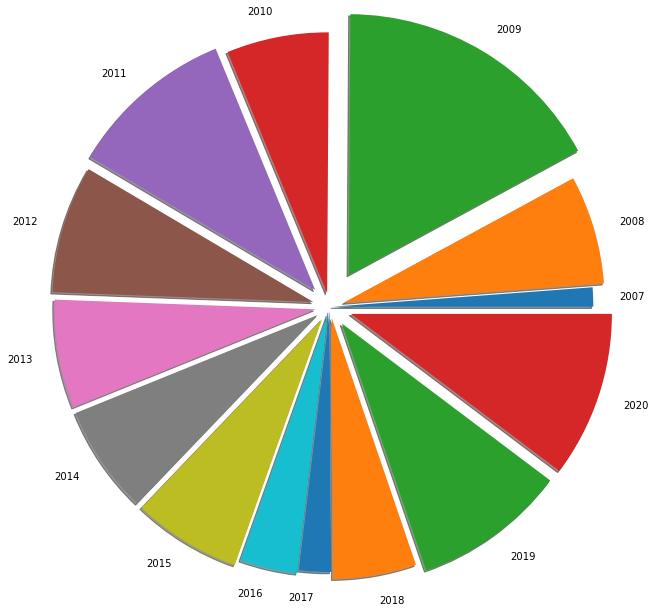

In [40]:
_data = pd.DataFrame([datetime.now().year-val for val in colors])
_data['pct'] = 0
_data = _data.groupby(0)
proportions = _data.count().apply(lambda x: x/x.sum()).values.tolist()
proportions = [p[0] for p in proportions]
years = _data.count().apply(lambda x: x/x.sum()).index.tolist()
plt.pie(proportions, labels=years, explode=[p*2.5 for p in proportions], shadow=True, radius=3);

Mezclando las dos redes analizadas, se comparten características. Existe una mayor proporción para usuarios creados en el 2009, pero es seguido por la cantidad de usuarios creados en el 2019 y 2020 respectivamente.

# Geo-referenciando Tweets

Un dato muy interesante que proveen los tweets y usuarios es `coordinates`, que corresponde a un punto con longitud y latitud de donde el tweet fue originado. El problema aquí es que muy pocos tweets y usuarios contienen esa información, y es imposible armar un mapa de los usuarios o tweets que corresponden a un contenido específico. Sin embargo, podemos hacer un intento con los tweets descargados que sí contienen esta información.

In [41]:
df_geo_covid19 = df_geo[df_geo['text'].apply(lambda t: True if 'covid19' in t.lower() else False)]
df_geo_filmyourhospital = df_geo[df_geo['text'].apply(lambda t: True if 'filmyourhospital' in t.lower() else False)]
df_geo_plandemic = df_geo[df_geo['text'].apply(lambda t: True if 'plandemic' in t.lower() else False)]
print(f"There are {len(df_geo_covid19)} tweets refering to covid19 with georeference.")
print(f"There are {len(df_geo_filmyourhospital)} tweets refering to FilmYourHospital with georeference.")
print(f"There are {len(df_geo_plandemic)} tweets refering to Plandemic with georeference.")

There are 26 tweets refering to covid19 with georeference.
There are 0 tweets refering to FilmYourHospital with georeference.
There are 4 tweets refering to Plandemic with georeference.


Solo los hashtags #covid19 y #plandemic devolvieron tweets con georeferencia, así que grafico estos tweets en un mapa del planeta.

Plotting geographical origin of tweets containing covid19...


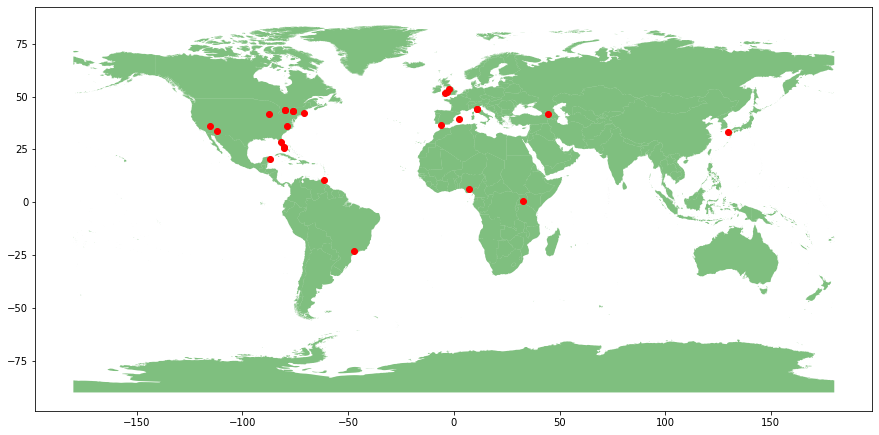

In [42]:
coordinates = df_geo_covid19['coordinates'].tolist()
coordinates = [eval(c)['coordinates'] for c in coordinates]

# Se genera el mapa del mundo
map = gpd.read_file('TM_WORLD_BORDERS-0.3.shp')

# Datos exactos
geometry = [Point(xy) for xy in coordinates]
geo_df_ = gpd.GeoDataFrame(geometry= geometry)

fig, ax = plt.subplots(figsize=(15, 15))
print("Plotting geographical origin of tweets containing covid19...")
# Plot de puntos rojos
map.plot(ax=ax, alpha=0.5, color='green');
geo_df_.plot(ax=ax, color='red');


Plotting geographical origin of tweets containing Plandemic...b


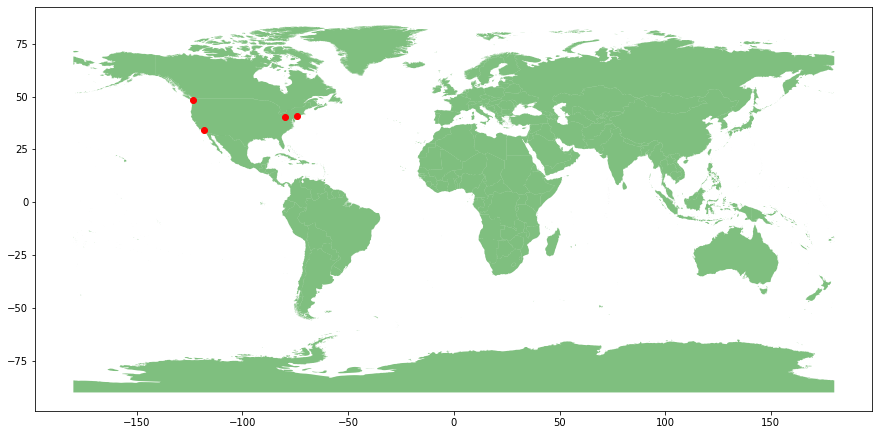

In [43]:
coordinates = df_geo_plandemic['coordinates'].tolist()
coordinates = [eval(c)['coordinates'] for c in coordinates]

# Se genera el mapa del mundo
map = gpd.read_file('TM_WORLD_BORDERS-0.3.shp')

# Datos exactos
geometry = [Point(xy) for xy in coordinates]
geo_df_ = gpd.GeoDataFrame(geometry= geometry)

fig, ax = plt.subplots(figsize=(15, 15))
print("Plotting geographical origin of tweets containing Plandemic...b")
# Plot de puntos rojos
map.plot(ax=ax, alpha=0.5, color='green');
geo_df_.plot(ax=ax, color='red');


Se puede ver que los tweets que contienen *covid19* se encuentran esparcidos en el mundo, pero concentrados en Norteamérica y Europa, mientras que los tweets de *plandemic* se encuentran solo en EEUU, pero son muy pocos como para dar confianza estadística.

# Conclusiones y futuro trabajo

En este breve estudio de divulgación de fake news se pudo visualizar perspectivas interesantes de los tweets que promueven información falsa y la interacción usuarios tinen con respecto a ese contenido. No se encontró información extremadamente reveladora sobre los usuarios que siguen y comparten fake news en los análisis, pero sí se pudo ver una ligera tendencia de doble modalidad en las edades de los usuarios que interactúan con fuentes de información falsa.

Existen varias formas para refinar el detalle de análisis de este estudio. En primera instancia, sería interesante ver el rango completo de tweets y seguidores con respecto al tema analizado. Esto se puede lograr con credenciales Premium para una aplicación de Twitter, pero eso sería justificado con un estudio masivo sobre fake news. Por otro lado, el estudio sería mucho más refinado y escalable si el proceso de selección de tweets a analizar se hace mediante Deep Learning para la clasificación de tweets según su grado de credibilidad. Existen muchos estudios que analizan distintas formas de usar Natural Language Processing para identificar tweets maliciosos, y también existen bases de datos de tweets ya clasificados para entrenar redes neuronales (Atodiresei, Tănăselea, 2018).

Un punto adicional e interesante que expandiría este proyecto es incluir un análisis de las palabras más comunes en las descripciones de los usuarios en la red de conxiones de un tweet y usuario analizado. En ese caso se podrían descubrir características sociales comunes entre dichos usuarios. Aún más alla, se podría utilizar un algoritmo de clustering para agrupar los usuario según sus características más predonminantes.

# Referencias

* Gruzd, A., & Mai, P. (n.d.). *The Latest Conspiracy About The Coronavirus Pandemic Is as Dumb as The Rest of Them*. Retrieved from https://www.sciencealert.com/the-latest-conspiracy-about-the-coronavirus-pandemic-is-as-dumb-as-the-rest-of-them
* Herbert, G. (2020, May 7). *YouTube removes 'Plandemic' video with coronavirus claims by Dr. Judy Mikovits*. Retrieved from https://www.syracuse.com/coronavirus/2020/05/youtube-removes-plandemic-video-with-coronavirus-claims-by-dr-judy-mikovits.html
* Atodiresei, C., & S., Tănăselea, A., & Iftene, A. (2018). *Identifying Fake News and Fake Users on Twitter*. Procedia Computer Science, 126, 451–461. doi: 10.1016/j.procs.2018.07.279